In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
#import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords

#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

from imblearn.over_sampling import RandomOverSampler

#FeatureEngineering
#!pip install lightgbm
#from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import  textblob
#import xgboost
#from keras.preprocessing import text, sequence
#from keras import layers, models, optimizers

from textblob import TextBlob
from nltk.stem import PorterStemmer
import nltk
#nltk.download('wordnet')
from textblob import Word

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

Using TensorFlow backend.


In [2]:
# read Bank.csv into a DataFrame
Bank = pd.read_excel('C:/Users/Yash/Desktop/STATS/CASE STUDY FOR ML/5. Bank Reviews-Complaints Analysis/BankReviews.xlsx')


In [3]:
Bank.head(5)

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [4]:
Bank=Bank[['Stars', 'Reviews',  'BankName']]

In [5]:
Bank.head()

,Stars,Reviews,BankName
0,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [6]:
df = Bank

### Basic Exploratory Analysis

#### Note: It may take some time to process the function if the data is huge

In [7]:
df['Reviews'] = df['Reviews'].astype(str)
df['count_sent']=df["Reviews"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
df['count_word']=df["Reviews"].apply(lambda x: len(str(x).split()))

#Unique word count
df['count_unique_word']=df["Reviews"].apply(lambda x: len(set(str(x).split())))

#Letter count
df['count_letters']=df["Reviews"].apply(lambda x: len(str(x)))

#Word density

df['word_density'] = df['count_letters'] / (df['count_word']+1)

#punctuation count
df["count_punctuations"] =df["Reviews"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df["count_words_upper"] = df["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#upper case words count
df["count_words_lower"] = df["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.islower()]))

#title case words count
df["count_words_title"] = df["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df["count_stopwords"] = df["Reviews"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#Average length of the words
df["mean_word_len"] = df["Reviews"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#Number of numeric
df['numeric'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isdigit()]))

#Number of alphanumeric
df['alphanumeric'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isalnum()]))

#Number of alphabetics
df['alphabetetics'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isalpha()]))

#Number of alphabetics
df['Spaces'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isspace()]))

#Number of Words ends with
df['words_ends_with_et'] = df['Reviews'].apply(lambda x :len([x for x in x.lower().split() if x.endswith('et')]))

#Number of Words ends with
df['words_start_with_no'] = df['Reviews'].apply(lambda x :len([x for x in x.lower().split() if x.startswith('no')]))

# Count the occurences of all words
df['wordcounts'] = df['Reviews'].apply(lambda x :dict([ [t, x.split().count(t)] for t in set(x.split()) ]))

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

df['noun_count'] = df['Reviews'].apply(lambda x: check_pos_tag(x, 'noun'))
df['verb_count'] = df['Reviews'].apply(lambda x: check_pos_tag(x, 'verb'))
df['adj_count']  = df['Reviews'].apply(lambda x: check_pos_tag(x, 'adj'))
df['adv_count']  = df['Reviews'].apply(lambda x: check_pos_tag(x, 'adv'))
df['pron_count'] = df['Reviews'].apply(lambda x: check_pos_tag(x, 'pron')) 

### Calculating Sentiment analysis using Textblob module

In [8]:
# sentiment.polarity ---will tell polarity is >0 means positive(accept) <0 is negitive(reject)

# Textblob has al ready the negitive and postive PHRASES to use thats how polarity is calculated

df['sentiment'] = df["Reviews"].apply(lambda x: TextBlob(x).sentiment.polarity )

In [9]:
Bank.Stars.value_counts()

5    410
1     95
Name: Stars, dtype: int64

### Split the data into train & Test

In [10]:
# create a new DataFrame that only contains the 5-star and 1-star reviews
#Bank_best_worst = Bank[(Bank.stars==5) | (Bank.stars==1)]

# define X and y
X = Bank.Reviews
y = Bank.Stars

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(378,)
(127,)
(378,)
(127,)


In [11]:
Bank.shape

(505, 27)

In [12]:
Bank.head()

,Stars,Reviews,BankName,count_sent,count_word,count_unique_word,count_letters,word_density,count_punctuations,count_words_upper,...,Spaces,words_ends_with_et,words_start_with_no,wordcounts,noun_count,verb_count,adj_count,adv_count,pron_count,sentiment
0,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,1,19,19,126,6.300000,4,0,...,0,0,0,"{'you!': 1, 'and': 1, 'smoothly.': 1, 'through...",8,3,1,1,3,0.533333
1,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,1,25,23,159,6.115385,4,0,...,0,0,0,"{'service,': 1, 'and': 1, 'much': 1, 'He': 1, ...",7,3,4,2,4,0.453333
2,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,1,79,64,462,5.775000,8,0,...,0,0,1,"{'only': 1, 'Wyndham!!': 1, 'and': 4, 'would':...",24,10,5,8,8,-0.033231
3,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,1,108,78,605,5.550459,9,0,...,0,0,1,"{'pulled': 1, 'found': 1, 'ultimately': 1, 'pr...",30,17,8,7,11,0.093740
4,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,1,59,47,341,5.683333,6,3,...,0,0,1,"{'service,': 1, 'and': 4, 'I': 3, 'took': 1, '...",16,9,4,4,8,0.125000


In [13]:
bank_best_worst = Bank[(Bank.Stars==5) | (Bank.Stars==1)]
bank_best_worst.head().T

,0,1,2,3,4
Stars,5,5,5,5,5
Reviews,"Great job, Wyndham Capital! Each person was pr...",Matthew Richardson is professional and helpful...,We had a past experience with Wyndham Mortgage...,We have been dealing with Brad Thomka from the...,I can't express how grateful I am for the supp...
BankName,Wyndham Capital Mortgage,Wyndham Capital Mortgage,Wyndham Capital Mortgage,Wyndham Capital Mortgage,Wyndham Capital Mortgage
count_sent,1,1,1,1,1
count_word,19,25,79,108,59
count_unique_word,19,23,64,78,47
count_letters,126,159,462,605,341
word_density,6.3,6.11538,5.775,5.55046,5.68333
count_punctuations,4,4,8,9,6
count_words_upper,0,0,0,0,3


### Creating user defined functions for clean the text and pre-process the data

In [14]:
#Abbrevations and Words correction
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r' +', ' ', text)
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", text)
    return(text)

In [15]:
stop = set(nltk.corpus.stopwords.words('english'))

nltk.corpus.stopwords.words('english') #tells the stop word in english

#nltk.corpus.stopwords.words('french') #tells the stop word in french ETC ETC

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [16]:
import string
def pre_process(text):
    #text = text.str.replace('/','')                           #Replacing the / with none
    #text = text.apply(lambda x: re.sub("  "," ", x))          #Replacing double space with single space
    #text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,']", "", text)      #Replacing special character with none
    #text = re.sub(r'[0-9]+', '', text)                        #Replacing numbers with none
    #text = text.apply(lambda x: " ".join(x.translate(str.maketrans('', '', string.punctuation)) for x in x.split() if x.isalpha()))
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #Removing stop words
    #text = text.apply(lambda x: str(TextBlob(x).correct()))                      #Correct spelling corrections
    #text = text.apply(lambda x: " ".join(PorterStemmer().stem(word) for word in x.split())) #Stemming using porter stemmer
    #text = text.apply(lambda x: " ".join(stemmer_func(word) for word in x.split()))        #Stemming
    #text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))   #lemmatization
    #text = text.apply(lambda x: " ".join(word for word, pos in pos_tag(x.split()) if pos not in ['NN','NNS','NNP','NNPS'])) #Removing nouns etc
    return(text)

In [17]:
X_train = X_train.apply(lambda x: clean_text(x))
X_test = X_test.apply(lambda x: clean_text(x))

In [18]:
X_train=pre_process(X_train)
X_test=pre_process(X_test)

### Vectorization (Count, Tfidf, Hashing)
        - Charter level
        - Word level
        - n-grams

In [19]:
#Train
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), max_df=0.9,
                             min_df=0.01, 
                             encoding='latin-1' ,
                             max_features=800)
xtrain_count = count_vect.fit_transform(X_train)

In [20]:
xtrain_count

<378x732 sparse matrix of type '<class 'numpy.int64'>'
	with 9755 stored elements in Compressed Sparse Row format>

### View the document term metrics

In [21]:
dtm=xtrain_count.toarray()

In [22]:
dtm

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [23]:
count_vect.get_feature_names()

['aaron',
 'ability',
 'able',
 'absolutely',
 'accept',
 'accommodating',
 'account',
 'accurate',
 'achieve',
 'across',
 'actual',
 'actually',
 'adam',
 'adan',
 'additional',
 'advice',
 'agent',
 'agreed',
 'alex',
 'almost',
 'along',
 'already',
 'also',
 'always',
 'amazing',
 'american',
 'amount',
 'another',
 'answer',
 'answered',
 'answering',
 'answers',
 'anthony',
 'anyone',
 'anything',
 'application',
 'apply',
 'appraisal',
 'appraiser',
 'appreciate',
 'appreciated',
 'approved',
 'around',
 'ask',
 'asked',
 'asking',
 'aspects',
 'asset',
 'attention',
 'attentive',
 'attorney',
 'available',
 'away',
 'awesome',
 'back',
 'bad',
 'balance',
 'bank',
 'banks',
 'barrett',
 'based',
 'basis',
 'beat',
 'became',
 'began',
 'beginning',
 'believe',
 'beneficial',
 'best',
 'better',
 'beyond',
 'big',
 'bob',
 'brent',
 'broker',
 'brokers',
 'bumps',
 'business',
 'buy',
 'buyer',
 'buyers',
 'buying',
 'ca',
 'call',
 'called',
 'calling',
 'calls',
 'calm',
 'ca

In [24]:
dtm1=pd.DataFrame(dtm)

In [25]:
dtm1.columns=count_vect.get_feature_names()

In [26]:
dtm1.head()

,aaron,ability,able,absolutely,accept,accommodating,account,accurate,achieve,across,...,worth,would,wouldnt,writing,written,wrong,wyndham,year,years,yet
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Vectorization (count, tfidf) for both train & test

In [27]:
#Train
count_vect = CountVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' , 
                             max_features=800)

xtrain_count = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(xtrain_count)

#Test
#count_vect = CountVectorizer()
xtest_count = count_vect.transform(X_test)

#tfidf_transformer = TfidfTransformer()
X_test_tfidf = tfidf_transformer.transform(xtest_count)


In [28]:
dtm2=pd.DataFrame(X_train_tfidf.toarray(), columns=count_vect.get_feature_names())

In [29]:
dtm2.head(10)

,aaron,able,absolutely,accept,accommodating,account,accurate,across,actual,adam,...,working,works,would,wouldnt,writing,wrong,wyndham,year,years,yet
0,0.0,0.0,0.000000,0.133259,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.123737,0.0,0.0,0.0,0.0,0.096250,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.194406,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.130702,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.121363,0.0,0.0,0.0,0.0,0.094403,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
5,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.084774,0.175643,0.0,0.0,0.0,0.0,0.000000,0.0
6,0.0,0.0,0.000000,0.000000,0.0,0.0,0.256938,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
7,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.068074,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
8,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
9,0.0,0.0,0.228774,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [30]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', ngram_range=(1, 2), max_features=800)
tfidf_vect_ngram.fit(df['Reviews'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

### Create user defined function for train the models

In [31]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,  valid_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(classifier.predict(feature_vector_train), label), metrics.accuracy_score(predictions, valid_y)

### Building different models with different vectors  (multiclass)

In [32]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[  1   5]
 [ 70 308]]


In [33]:
#!pip install imblearn
ros = RandomOverSampler(random_state=123)

X_train_tfidf_os, y_train_tfidf_os = ros.fit_sample(X_train_tfidf, y_train)

X_train_cnt_os, y_train_cnt_os = ros.fit_sample(xtrain_count, y_train)

X_train_tfidf_ngram_os, y_train_tfidf_ngram_os = ros.fit_sample(xtrain_tfidf_ngram, y_train)

unique_elements, counts_elements = np.unique(y_train_tfidf_os, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[  1   5]
 [308 308]]


In [34]:
#Naive Bayes
# Naive Bayes on TF-IDF
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_os, y_train_tfidf_os, X_test_tfidf, y_test)
print("NB  for L1, Count Vectors: ", accuracy_L1)

# Naive Bayes on Word Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), X_train_cnt_os, y_train_cnt_os, xtest_count, y_test)
print("NB  for L1, WordLevel TF-IDF: ", accuracy_L1)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram_os, y_train_tfidf_ngram_os, xtest_tfidf_ngram, y_test)
print("NB  for L1, N-Gram Vectors: ", accuracy_L1)

# gap between train and test is high so reject if its less we could use it
#0.617335352006056 train score
#0.4752 test score

NB  for L1, Count Vectors:  (0.9756493506493507, 0.952755905511811)
NB  for L1, WordLevel TF-IDF:  (0.9724025974025974, 0.9606299212598425)
NB  for L1, N-Gram Vectors:  (0.9675324675324676, 0.9448818897637795)


In [35]:
#Logistic Regression
# Logistic Regression on Count Vectors and TF-IDF
accuracy_L1 = train_model(LogisticRegression(), X_train_tfidf_os, y_train_tfidf_os, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)



# Logistic Regression on Word Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), X_train_cnt_os, y_train_cnt_os, xtest_count, y_test)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# Logistic Regression on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), X_train_tfidf_ngram_os, y_train_tfidf_ngram_os, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)

# gap between train and test is high so reject if its less we could use it

#0.6820590461771385 train score
# 0.4672 test score

LR  for L1, Count Vectors:  (0.9837662337662337, 0.968503937007874)
LR  for L1, WordLevel TF-IDF:  (0.9983766233766234, 0.9763779527559056)
LR  for L1, N-Gram Vectors:  (0.9756493506493507, 0.9606299212598425)


In [36]:
#Linear SVC
# Linear SVC on Count Vectors and TF-IDF
accuracy_L1 = train_model(SVC(), X_train_tfidf_os, y_train_tfidf_os, X_test_tfidf, y_test)
print("SVC  for L1, Count Vectors: ", accuracy_L1)



# Linear SVC on Word Level TF IDF Vectors
accuracy_L1 = train_model(SVC(), X_train_cnt_os, y_train_cnt_os, xtest_count, y_test)
print("SVC  for L1, WordLevel TF-IDF: ", accuracy_L1)



# Linear SVC on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(SVC(), X_train_tfidf_ngram_os, y_train_tfidf_ngram_os, xtest_tfidf_ngram, y_test)
print("SVC  for L1, N-Gram Vectors: ", accuracy_L1)

# gap between train and test is high so reject if its less we could use it

#0.5229371688115064 train score
#0.3496 test score

SVC  for L1, Count Vectors:  (0.9983766233766234, 0.937007874015748)
SVC  for L1, WordLevel TF-IDF:  (0.9756493506493507, 0.9448818897637795)
SVC  for L1, N-Gram Vectors:  (0.9983766233766234, 0.9448818897637795)


### Adding Features to a Document-Term Matrix (binarly class)

In [37]:
# create a DataFrame that only contains the 5-star and 1-star reviews

Bank['Stars'] = np.where(Bank['Stars']>3, 5, np.where(Bank['Stars']<3,1,3))

Bank = Bank[(Bank.Stars==5) | (Bank.Stars==1)]

# define X and y
feature_cols = ['Reviews']
X = Bank[feature_cols]
y = Bank.Stars

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [38]:
# use CountVectorizer with text column only
vect = TfidfVectorizer(lowercase=True, stop_words='english', max_features=1000, min_df=5, ngram_range=(1, 2))
X_train_dtm = vect.fit_transform(X_train.Reviews)
X_test_dtm = vect.transform(X_test.Reviews)
print(X_train_dtm.shape)
print(X_test_dtm.shape)

# shape of other four feature columns
X_train.drop('Reviews', axis=1).shape

(378, 627)
(127, 627)


(378, 0)

In [39]:
# use CountVectorizer with text column only
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train.Reviews)
X_test_dtm = vect.transform(X_test.Reviews)
print(X_train_dtm.shape)
print(X_test_dtm.shape)

# shape of other four feature columns
X_train.drop('Reviews', axis=1).shape

(378, 2438)
(127, 2438)


(378, 0)

In [40]:
# cast other feature columns to float and convert to a sparse matrix
extra = sparse.csr_matrix(X_train.drop('Reviews', axis=1).astype(float))
extra.shape

# combine sparse matrices
X_train_dtm_extra = sparse.hstack((X_train_dtm, extra))
X_train_dtm_extra.shape

# repeat for testing set
extra = sparse.csr_matrix(X_test.drop('Reviews', axis=1).astype(float))
X_test_dtm_extra = sparse.hstack((X_test_dtm, extra))
X_test_dtm_extra.shape

(127, 2438)

In [41]:
# use logistic regression with text column only
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.roc_auc_score(y_test, y_pred_class))
acc_log1=metrics.accuracy_score(y_test, y_pred_class)
acc_log1

0.952755905511811
0.9101960784313725


0.952755905511811

In [42]:
# use logistic regression with all features
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm_extra, y_train)
y_pred_class = logreg.predict(X_test_dtm_extra)
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.roc_auc_score(y_test, y_pred_class))

0.952755905511811
0.9101960784313725


In [43]:
# use random forest with text column only
from sklearn.ensemble import RandomForestClassifier
rmf = RandomForestClassifier()
rmf.fit(X_train_dtm, y_train)
y_pred_class = rmf.predict(X_test_dtm)
acc_rmf=metrics.accuracy_score(y_test, y_pred_class)
acc_rmf

0.889763779527559

In [44]:
# use random forest with all features

rmf = RandomForestClassifier()
rmf.fit(X_train_dtm_extra, y_train)
y_pred_class = rmf.predict(X_test_dtm_extra)
acc_rmf1=metrics.accuracy_score(y_test, y_pred_class)
acc_rmf1

0.905511811023622

In [45]:
# use gradient boosting with text column only
from sklearn.ensemble import GradientBoostingClassifier
gbc =  GradientBoostingClassifier()
gbc.fit(X_train_dtm, y_train)
y_pred_class = gbc.predict(X_test_dtm)
acc_grad=metrics.accuracy_score(y_test, y_pred_class)
acc_grad

0.9212598425196851

In [46]:
# use gradient boosting with all features
gbc = GradientBoostingClassifier()
gbc.fit(X_train_dtm_extra, y_train)
y_pred_class = gbc.predict(X_test_dtm_extra)
acc_grad1=metrics.accuracy_score(y_test, y_pred_class)
acc_grad1

0.9212598425196851

In [47]:
# use Xgboosting with text column only
from xgboost import XGBClassifier
xgb =  XGBClassifier()
xgb.fit(X_train_dtm, y_train)
y_pred_class = xgb.predict(X_test_dtm)
acc_xgb=metrics.accuracy_score(y_test, y_pred_class)
acc_xgb

0.952755905511811

In [48]:
# use Xgboosting with all features
xgb = XGBClassifier()
xgb.fit(X_train_dtm_extra, y_train)
y_pred_class = xgb.predict(X_test_dtm_extra)
acc_xgb1=metrics.accuracy_score(y_test, y_pred_class)
acc_xgb1

0.952755905511811

In [49]:
# use ANN with text column only
mp = MLPClassifier()
mp.fit(X_train_dtm, y_train)
y_pred_class = mp.predict(X_test_dtm)
acc_mlp=metrics.accuracy_score(y_test, y_pred_class)
acc_mlp

0.9763779527559056

In [50]:
# use ANN with all features
mp = MLPClassifier()
mp.fit(X_train_dtm_extra, y_train)
y_pred_class = mp.predict(X_test_dtm_extra)
acc_mlp1=metrics.accuracy_score(y_test, y_pred_class)
acc_mlp1

0.968503937007874

In [51]:
# use ANN+logistic with text column only
mp = MLPClassifier(activation='logistic')
mp.fit(X_train_dtm, y_train)
y_pred_class = mp.predict(X_test_dtm)
acc_mlp_ln=metrics.accuracy_score(y_test, y_pred_class)
acc_mlp_ln

0.9448818897637795

In [52]:
# use ANN+logistic with all features
mp = MLPClassifier(activation='logistic')
mp.fit(X_train_dtm_extra, y_train)
y_pred_class = mp.predict(X_test_dtm_extra)
acc_mlp_ln1=metrics.accuracy_score(y_test, y_pred_class)
acc_mlp_ln1

0.952755905511811

In [53]:
# use OneVsRest + XGBoosting with text column only
from sklearn.multiclass import OneVsRestClassifier
one_xgb = OneVsRestClassifier(XGBClassifier())
one_xgb.fit(X_train_dtm, y_train)
y_pred_class = one_xgb.predict(X_test_dtm)
acc_one_xgb=metrics.accuracy_score(y_test, y_pred_class)
acc_one_xgb


0.952755905511811

In [54]:
# use OneVsRest + XGBoosting with all features
one_xgb = OneVsRestClassifier(XGBClassifier())
one_xgb.fit(X_train_dtm_extra, y_train)
y_pred_class = one_xgb.predict(X_test_dtm_extra)
acc_one_xgb1=metrics.accuracy_score(y_test, y_pred_class)
acc_one_xgb1

0.952755905511811

Text(0.5, 16.0, 'Predicted label')

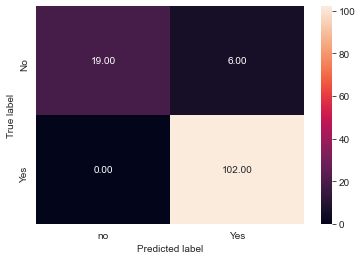

In [55]:
cm = metrics.confusion_matrix( y_test, y_pred_class)
sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["no", "Yes"] , yticklabels = ["No", "Yes"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Compairing all modes with each other

In [56]:
models = pd.DataFrame({
    'Model': ['Logistic Regression','Random Forest', 'XGBoosting','Gradient Boosting','ANN','ANN + logistic','OneVsRest + XGBoosting'],
    
    'Score': [acc_log1,acc_rmf,acc_grad,acc_xgb,acc_mlp,acc_mlp_ln,acc_one_xgb]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
4,ANN,0.976378
0,Logistic Regression,0.952756
3,Gradient Boosting,0.952756
6,OneVsRest + XGBoosting,0.952756
5,ANN + logistic,0.944882
2,XGBoosting,0.921260
1,Random Forest,0.889764


## Introduction to additional TextBlob features

TextBlob: "Simplified Text Processing"

In [57]:
print(Bank.Reviews[1])

Matthew Richardson is professional and helpful. He helped us find the correct product for our mortgage. Thank you very much for the excellent service, Matthew!


In [58]:
# print the first review
print(Bank.Reviews[0])

Great job, Wyndham Capital! Each person was professional and helped us move through our refinance process smoothly. Thank you!


In [59]:
# save it as a TextBlob object
review = TextBlob(Bank.Reviews[0])
#review1 = TextBlob('Good food, like it, excellent and recommended')
#review1

In [60]:
review.sentiment.polarity

0.5333333333333333

In [61]:
print(dir(review))

['__add__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cmpkey', '_compare', '_create_sentence_objects', '_strkey', 'analyzer', 'classifier', 'classify', 'correct', 'detect_language', 'ends_with', 'endswith', 'find', 'format', 'index', 'join', 'json', 'lower', 'ngrams', 'noun_phrases', 'np_counts', 'np_extractor', 'parse', 'parser', 'polarity', 'pos_tagger', 'pos_tags', 'raw', 'raw_sentences', 'replace', 'rfind', 'rindex', 'sentences', 'sentiment', 'sentiment_assessments', 'serialized', 'split', 'starts_with', 'startswith', 'string', 'strip', 'stripped', 'subjectivity', 'tags', 'title', 'to_json', 'tokenize', 'tokenizer', 'tokens', 'tra

In [62]:
print(review.ngrams(1))

[WordList(['Great']), WordList(['job']), WordList(['Wyndham']), WordList(['Capital']), WordList(['Each']), WordList(['person']), WordList(['was']), WordList(['professional']), WordList(['and']), WordList(['helped']), WordList(['us']), WordList(['move']), WordList(['through']), WordList(['our']), WordList(['refinance']), WordList(['process']), WordList(['smoothly']), WordList(['Thank']), WordList(['you'])]


In [63]:
review.sentiment.polarity

0.5333333333333333

In [64]:
# list the words
review.words

WordList(['Great', 'job', 'Wyndham', 'Capital', 'Each', 'person', 'was', 'professional', 'and', 'helped', 'us', 'move', 'through', 'our', 'refinance', 'process', 'smoothly', 'Thank', 'you'])

In [65]:
# list the sentences
review.sentences

[Sentence("Great job, Wyndham Capital!"),
 Sentence("Each person was professional and helped us move through our refinance process smoothly."),
 Sentence("Thank you!")]

In [66]:
# some string methods are available
review.lower()

TextBlob("great job, wyndham capital! each person was professional and helped us move through our refinance process smoothly. thank you!")

In [67]:
review.ngrams(n=2)

[WordList(['Great', 'job']),
 WordList(['job', 'Wyndham']),
 WordList(['Wyndham', 'Capital']),
 WordList(['Capital', 'Each']),
 WordList(['Each', 'person']),
 WordList(['person', 'was']),
 WordList(['was', 'professional']),
 WordList(['professional', 'and']),
 WordList(['and', 'helped']),
 WordList(['helped', 'us']),
 WordList(['us', 'move']),
 WordList(['move', 'through']),
 WordList(['through', 'our']),
 WordList(['our', 'refinance']),
 WordList(['refinance', 'process']),
 WordList(['process', 'smoothly']),
 WordList(['smoothly', 'Thank']),
 WordList(['Thank', 'you'])]

## Language correction, detection, translation etc...

In [68]:
# spelling correction
TextBlob('15 minuets late').correct()

TextBlob("15 minutes late")

In [69]:
s="this is my email adcresc"

In [70]:
TextBlob(s).correct()

TextBlob("this is my email address")

In [71]:
# spellcheck
Word('parot').spellcheck()

[('part', 0.9929478138222849), ('parrot', 0.007052186177715092)]

In [72]:
# definitions
Word('bank').define('v')

['tip laterally',
 'enclose with a bank',
 'do business with a bank or keep an account at a bank',
 'act as the banker in a game or in gambling',
 'be in the banking business',
 'put into a bank account',
 'cover with ashes so to control the rate of burning',
 'have confidence or faith in']

In [73]:
# language detection
TextBlob('టీమిండియా మాజీ ఓపెనర్‌ గౌతమ్ గంభీర్ మంగళవారం క్రికెట్‌కు రిటైర్‌మెంట్ ప్రకటించారు. దానిపై స్పందించిన బాలీవుడ్ స్టార్‌ షారుక్‌ ఖాన్‌ ఓ ట్వీట్ చేశారు').detect_language()

'te'

In [74]:
# Language Translation
a=' '.join(TextBlob('టీమిండియా మాజీ ఓపెనర్‌ గౌతమ్ గంభీర్ మంగళవారం క్రికెట్‌కు రిటైర్‌మెంట్ ప్రకటించారు. దానిపై స్పందించిన బాలీవుడ్ స్టార్‌ షారుక్‌ ఖాన్‌ ఓ ట్వీట్ చేశారు').translate(to='es').words)

print(a)

El ex abridor del Equipo India Gautam Gambhir anunció su retiro del cricket el martes En respuesta a esto la estrella de Bollywood Shah Rukh Khan tuiteó


## Stemming and Lemmatization

**Stemming:**

- **What:** Reduce a word to its base/stem/root form
- **Why:** Often makes sense to treat related words the same way
- **Notes:**
    - Uses a "simple" and fast rule-based approach
    - Stemmed words are usually not shown to users (used for analysis/indexing)
    - Some search engines treat words with the same stem as synonyms

In [75]:
# initialize stemmer
stemmer = nltk.stem.snowball.SnowballStemmer('english')
stemmer

In [76]:
review.words

WordList(['Great', 'job', 'Wyndham', 'Capital', 'Each', 'person', 'was', 'professional', 'and', 'helped', 'us', 'move', 'through', 'our', 'refinance', 'process', 'smoothly', 'Thank', 'you'])

In [77]:
# stem each word
print([stemmer.stem(word) for word in review.words])

['great', 'job', 'wyndham', 'capit', 'each', 'person', 'was', 'profession', 'and', 'help', 'us', 'move', 'through', 'our', 'refin', 'process', 'smooth', 'thank', 'you']


**Lemmatization**

- **What:** Derive the canonical form ('lemma') of a word
- **Why:** Can be better than stemming
- **Notes:** Uses a dictionary-based approach (slower than stemming)

In [78]:
review.words

WordList(['Great', 'job', 'Wyndham', 'Capital', 'Each', 'person', 'was', 'professional', 'and', 'helped', 'us', 'move', 'through', 'our', 'refinance', 'process', 'smoothly', 'Thank', 'you'])

In [79]:
# assume every word is a noun
print([word.lemmatize() for word in review.words])

['Great', 'job', 'Wyndham', 'Capital', 'Each', 'person', 'wa', 'professional', 'and', 'helped', 'u', 'move', 'through', 'our', 'refinance', 'process', 'smoothly', 'Thank', 'you']


In [80]:
# assume every word is a verb
print([word.lemmatize(pos='v') for word in review.words])

['Great', 'job', 'Wyndham', 'Capital', 'Each', 'person', 'be', 'professional', 'and', 'help', 'us', 'move', 'through', 'our', 'refinance', 'process', 'smoothly', 'Thank', 'you']
